In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [21]:
from dataset import load_svhn, random_split_train_val
from layers import FullyConnectedLayer, ReLULayer, ConvolutionalLayer, MaxPoolingLayer, Flattener
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD, Adam
from metrics import multiclass_accuracy
import cupy as cp
from model import RNN_Model
from copy import deepcopy
cp.cuda.runtime.setDevice(1)

In [4]:
import os
import pandas as pd

df = pd.read_csv('Steel_industry_data.csv')


In [5]:
df

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


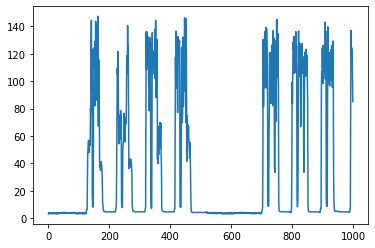

In [6]:
plt.plot(df['Usage_kWh'][:1000])

<AxesSubplot:>

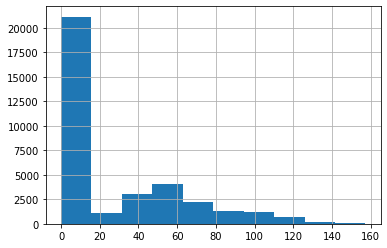

In [7]:
df['Usage_kWh'].hist()

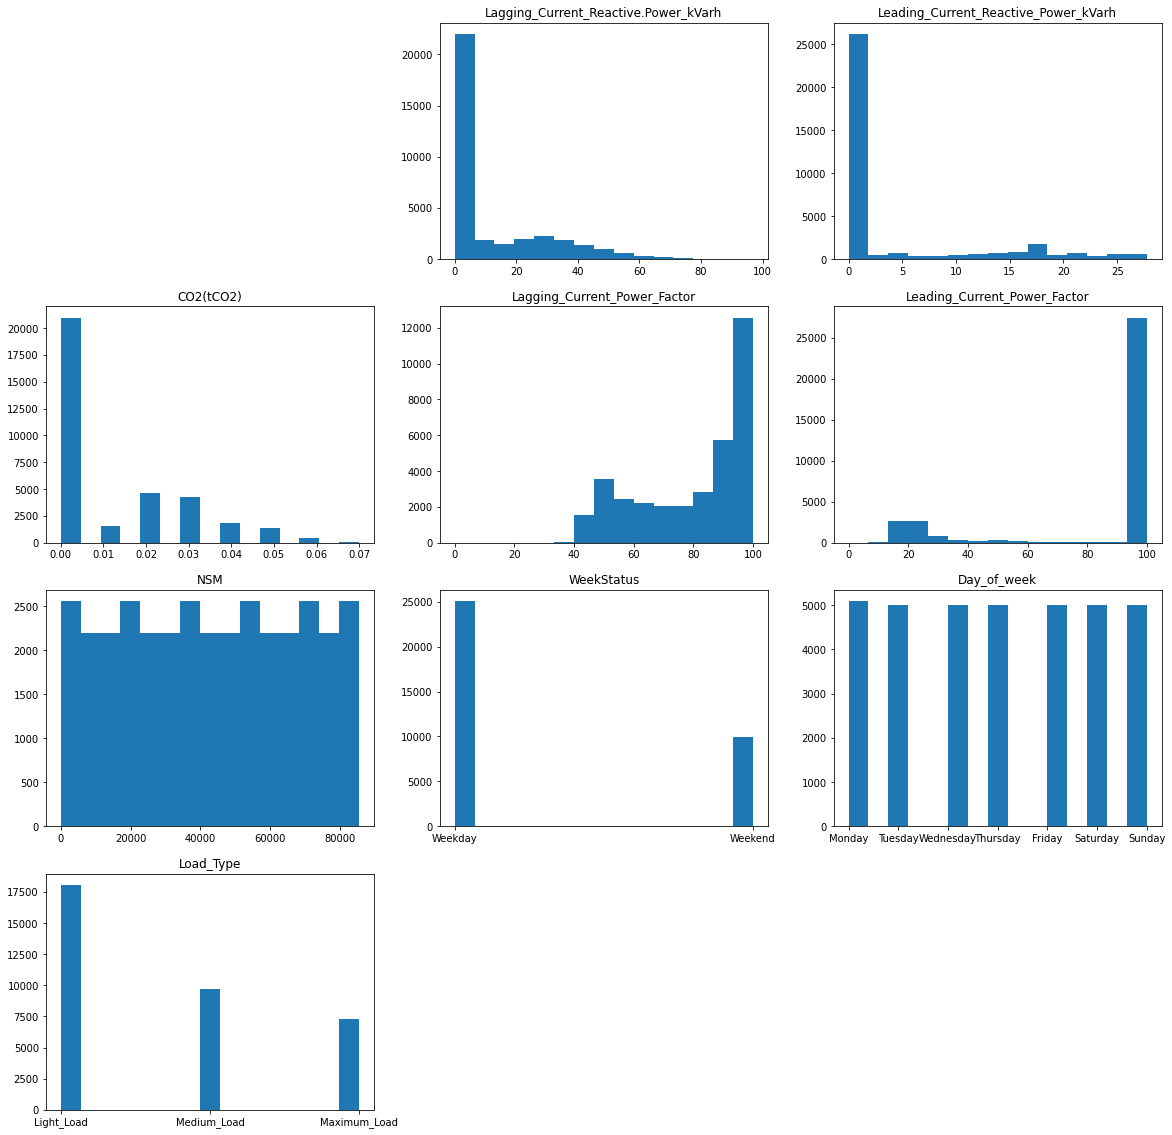

In [8]:
plt.figure(figsize=(20, 20))

for i, col in enumerate(df.columns):
    if col in ['date', 'Usage_kWh']:
        continue
    plt.subplot(4, 3, i)
    plt.hist(df[col], 15)
    plt.title(col)


In [9]:
df.columns[df.dtypes==object]

Index(['date', 'WeekStatus', 'Day_of_week', 'Load_Type'], dtype='object')

In [10]:
days = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2, 'Thursday' : 3, 'Friday' : 4, 'Saturday' :5, 'Sunday' : 6 }
df['Day_of_week'] = df['Day_of_week'].map(days)
df['WeekStatus'] = df['WeekStatus'].map({'Weekday' : 0, 'Weekend' : 1})
df['Load_Type'] = df['Load_Type'].map({'Light_Load' : 0, 'Medium_Load' : 1, 'Maximum_Load' : 2})


In [11]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [12]:
day_len_seconds = 24*60*60
year_len_seconds = (365.2425)*day_len_seconds

df['Time_sin'] = np.sin((df['date']-df['date'].min()).dt.total_seconds() * (2 * np.pi / day_len_seconds))
df['Date_sin'] = np.sin((df['date'] - df['date'].min()).dt.total_seconds() * (2 * np.pi / year_len_seconds))

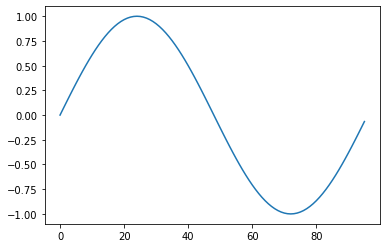

In [13]:
plt.plot(df['Time_sin'][:96] ) #сутки

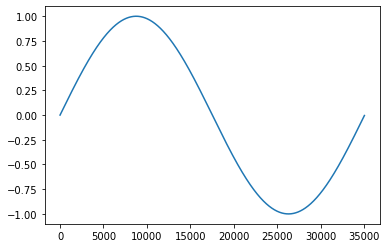

In [14]:
plt.plot(df['Date_sin'])

In [15]:
df = df.drop(columns=['date'])

In [16]:
from sklearn.preprocessing import MinMaxScaler
feature_columns = list(df.columns)
feature_columns.remove('Usage_kWh')
df[feature_columns] = MinMaxScaler().fit_transform(df[feature_columns])
df

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,Time_sin,Date_sin
0,3.42,0.035703,0.000000,0.0,0.7030,1.0000,0.000000,0.0,0.0,0.0,0.500000,0.500000
1,3.17,0.030441,0.000000,0.0,0.7321,1.0000,0.010526,0.0,0.0,0.0,0.532702,0.500090
2,4.00,0.046022,0.000000,0.0,0.6677,1.0000,0.021053,0.0,0.0,0.0,0.565263,0.500179
3,3.24,0.033846,0.000000,0.0,0.7028,1.0000,0.031579,0.0,0.0,0.0,0.597545,0.500269
4,3.31,0.036735,0.000000,0.0,0.6809,1.0000,0.042105,0.0,0.0,0.0,0.629410,0.500358
...,...,...,...,...,...,...,...,...,...,...,...,...
35035,3.82,0.046848,0.000000,0.0,0.6438,1.0000,0.957895,0.0,0.0,0.0,0.339280,0.497466
35036,3.85,0.050150,0.000000,0.0,0.6210,1.0000,0.968421,0.0,0.0,0.0,0.370590,0.497556
35037,3.74,0.038593,0.000000,0.0,0.7071,1.0000,0.978947,0.0,0.0,0.0,0.402455,0.497645
35038,3.78,0.032711,0.002522,0.0,0.7662,0.9998,0.989474,0.0,0.0,0.0,0.434737,0.497735


In [17]:
train_val_len = int(len(df) * 0.8)
test_len = len(df) - train_val_len
train_len = int(train_val_len * 0.8)
val_len = train_val_len-train_len

train_df = df[:train_len]
val_df = df[train_len:train_len+val_len]
test_df = df[train_len+val_len: train_len+val_len+test_len]

train_len, val_len, test_len

(22425, 5607, 7008)

In [36]:
from numpy.lib.stride_tricks import sliding_window_view

seq_len = 20
target_size = 1

def cut_df_to_dataset(df, seq_len, target_size, target_col):
    # features = df.drop(columns=[target_col]).to_numpy()
    # features = df[target_col].to_numpy()
    features = df.to_numpy()

    targets = df[target_col].to_numpy()
    
    x = sliding_window_view(features[0:-target_size], window_shape =(seq_len, 12))
    y = targets[seq_len:]
    x = np.squeeze(x, axis=1)
    return x.copy(), y.reshape(-1, 1).copy()
    # print(x.shape, y.shape)

    
X_train, y_train = cut_df_to_dataset(train_df, seq_len, target_size, 'Usage_kWh')
X_val, y_val = cut_df_to_dataset(val_df, seq_len, target_size, 'Usage_kWh')
X_test, y_test = cut_df_to_dataset(test_df, seq_len, target_size, 'Usage_kWh')
X_train.shape, y_train.shape

((22405, 20, 12), (22405, 1))

## RNN

In [26]:
# seq len = 8

def setup_optimizers(model):
    params = model.params()
    model.optimizers = {}
    for param_name, param in params.items():
        model.optimizers[param_name] = deepcopy(model.optim)
        
        
model = RNN_Model(12, 100)

# X_train = cp.array(X_train)
# y_train = cp.array(y_train)
# X_val = cp.array(X_val)
# y_val = cp.array(y_val)
model.optim = Adam()
setup_optimizers(model)


mempool = cp.get_default_memory_pool()

epoch_num = 10000
learning_rate = 1e-3
num_train = len(X_train)
batch_size=len(X_train) #1024*16
X_val_gpu = cp.array(X_val)
y_val_gpu = cp.array(y_val)

best_val_loss = 9999999

for epoch in range(epoch_num):
    
    shuffled_indices = np.arange(num_train)
    np.random.shuffle(shuffled_indices)
    sections = np.arange(batch_size, num_train, batch_size)
    batches_indices = np.array_split(shuffled_indices, sections)
    batch_losses = np.zeros(len(batches_indices))
    
    for batch_id, batch_indices in (enumerate(batches_indices)):
        batch_X = X_train[batch_indices]
        batch_y = y_train[batch_indices]
        
        batch_y_gpu = cp.asarray(batch_y) 
        batch_X_gpu = cp.asarray(batch_X)
        
        out = model.forward(batch_X_gpu)
        train_loss = cp.mean((out-batch_y_gpu)**2)
        
        grad = out-batch_y_gpu
        
        # if cp.isnan(train_loss):
        # print(cp.abs(out).max())
    
        for param in model.params().values():
            param.grad.fill(0)
        model.backward(grad)
    
        for param_name, param in model.params().items():
            optimizer = model.optimizers[param_name]
            optimizer.update(param.value, param.grad, learning_rate)
        
        batch_losses[batch_id] = train_loss.get()
        mempool.free_all_blocks()
        
    
    val_out = model.forward(X_val_gpu)
    val_loss = cp.mean((val_out-y_val_gpu)**2)
    
    if val_loss<best_val_loss:
        best_val_loss = val_loss
        # print(f'New best val loss: {val_loss}')
        for param_name, param in model.params().items():
            cp.save(f'best_rnn_model/{param_name}.npy', param.value)
    
    
    # val_loss=-1
    if epoch % 50 == 0:
        print(f'Epoch {epoch}:  Train loss: {batch_losses.mean():.5f}  Val loss: {val_loss:.5f}')
    

Epoch 0:  Train loss: 1971.80072  Val loss: 1454.61050
Epoch 50:  Train loss: 559.19488  Val loss: 433.18425
Epoch 100:  Train loss: 487.82485  Val loss: 373.24732
Epoch 150:  Train loss: 412.45110  Val loss: 312.07764
Epoch 200:  Train loss: 346.95364  Val loss: 259.05852
Epoch 250:  Train loss: 298.47737  Val loss: 219.89036
Epoch 300:  Train loss: 265.38692  Val loss: 193.16677
Epoch 350:  Train loss: 243.30101  Val loss: 175.31819
Epoch 400:  Train loss: 224.16759  Val loss: 158.93854
Epoch 450:  Train loss: 210.56644  Val loss: 148.91412
Epoch 500:  Train loss: 204.61282  Val loss: 143.77295
Epoch 550:  Train loss: 202.86738  Val loss: 142.00366
Epoch 600:  Train loss: 202.09690  Val loss: 141.30008
Epoch 650:  Train loss: 201.31472  Val loss: 140.71879
Epoch 700:  Train loss: 200.49384  Val loss: 140.11051
Epoch 750:  Train loss: 199.63830  Val loss: 139.33205
Epoch 800:  Train loss: 197.65490  Val loss: 138.59605
Epoch 850:  Train loss: 196.47161  Val loss: 137.83400
Epoch 900: 

KeyboardInterrupt: 

In [27]:
best_model = RNN_Model(12, 100)
best_model.load_params('best_rnn_model')

In [28]:
test = cp.array(X_test)
pred = best_model.forward(test)

In [29]:
pred = pred.get()

In [30]:
np.mean((pred - y_test)**2)

166.63052408113157

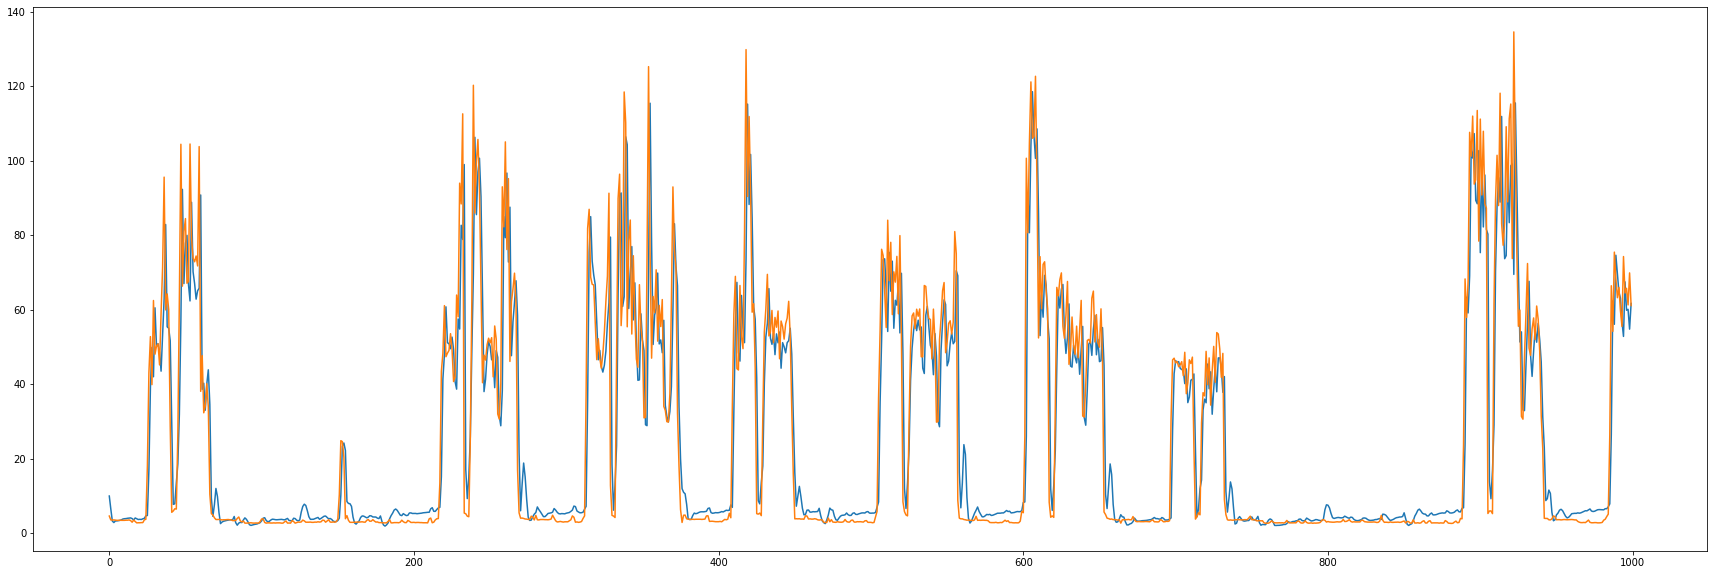

In [31]:
plt.figure(figsize=(30, 10))

plt.plot(pred[:1000])
plt.plot(y_test[:1000])

## LSTM

In [37]:
from model import LSTM_Model
# seq len = 20
def setup_optimizers(model):
    params = model.params()
    model.optimizers = {}
    for param_name, param in params.items():
        model.optimizers[param_name] = deepcopy(model.optim)
        
        
# model = RNN_Model(12, 100)
model = LSTM_Model(12, 20)

# X_train = cp.array(X_train)
# y_train = cp.array(y_train)
# X_val = cp.array(X_val)
# y_val = cp.array(y_val)
model.optim = Adam()
setup_optimizers(model)


mempool = cp.get_default_memory_pool()

epoch_num = 10000
learning_rate = 1e-2
num_train = len(X_train)
batch_size=len(X_train) #1024*16
X_val_gpu = cp.array(X_val)
y_val_gpu = cp.array(y_val)

best_val_loss = 9999999

for epoch in range(epoch_num):
    
    shuffled_indices = np.arange(num_train)
    np.random.shuffle(shuffled_indices)
    sections = np.arange(batch_size, num_train, batch_size)
    batches_indices = np.array_split(shuffled_indices, sections)
    batch_losses = np.zeros(len(batches_indices))
    
    for batch_id, batch_indices in (enumerate(batches_indices)):
        batch_X = X_train[batch_indices]
        batch_y = y_train[batch_indices]
        
        batch_y_gpu = cp.asarray(batch_y) 
        batch_X_gpu = cp.asarray(batch_X)
        
        out = model.forward(batch_X_gpu)
        train_loss = cp.mean((out-batch_y_gpu)**2)
        
        grad = out-batch_y_gpu
        
        # if cp.isnan(train_loss):
        # print(cp.abs(out).max())
    
        for param in model.params().values():
            param.grad.fill(0)
        model.backward(grad)
    
        for param_name, param in model.params().items():
            optimizer = model.optimizers[param_name]
            optimizer.update(param.value, param.grad, learning_rate)
        
        batch_losses[batch_id] = train_loss.get()
        mempool.free_all_blocks()
        
    
    val_out = model.forward(X_val_gpu)
    val_loss = cp.mean((val_out-y_val_gpu)**2)
    
    if val_loss<best_val_loss:
        best_val_loss = val_loss
        # print(f'New best val loss: {val_loss}')
        for param_name, param in model.params().items():
            cp.save(f'best_lstm_model/{param_name}.npy', param.value)
    
    
    # val_loss=-1
    if epoch % 25 == 0:
        print(f'Epoch {epoch}:  Train loss: {batch_losses.mean():.5f}  Val loss: {val_loss:.5f}')
    

Epoch 0:  Train loss: 1972.89821  Val loss: 1451.82619
Epoch 25:  Train loss: 1797.32929  Val loss: 1310.13094
Epoch 50:  Train loss: 1580.76088  Val loss: 1146.81245
Epoch 75:  Train loss: 1383.67979  Val loss: 991.51396
Epoch 100:  Train loss: 1205.39826  Val loss: 854.68020
Epoch 125:  Train loss: 1054.01844  Val loss: 740.27136
Epoch 150:  Train loss: 925.90396  Val loss: 644.59079
Epoch 175:  Train loss: 817.21621  Val loss: 563.78385
Epoch 200:  Train loss: 725.01043  Val loss: 496.20313
Epoch 225:  Train loss: 646.62025  Val loss: 439.56346
Epoch 250:  Train loss: 580.30858  Val loss: 392.17398
Epoch 275:  Train loss: 523.75642  Val loss: 352.67396
Epoch 300:  Train loss: 475.86878  Val loss: 320.60410
Epoch 325:  Train loss: 435.02818  Val loss: 293.79863
Epoch 350:  Train loss: 400.57102  Val loss: 271.72395
Epoch 375:  Train loss: 374.45770  Val loss: 254.80463
Epoch 400:  Train loss: 389.09040  Val loss: 272.41508
Epoch 425:  Train loss: 409.98596  Val loss: 290.58718
Epoch 

In [38]:
best_model = LSTM_Model(12, 20)
best_model.load_params('best_lstm_model')
test = cp.array(X_test)
pred = best_model.forward(test)
pred = pred.get()

np.mean((pred - y_test)**2)

137.46150978223696

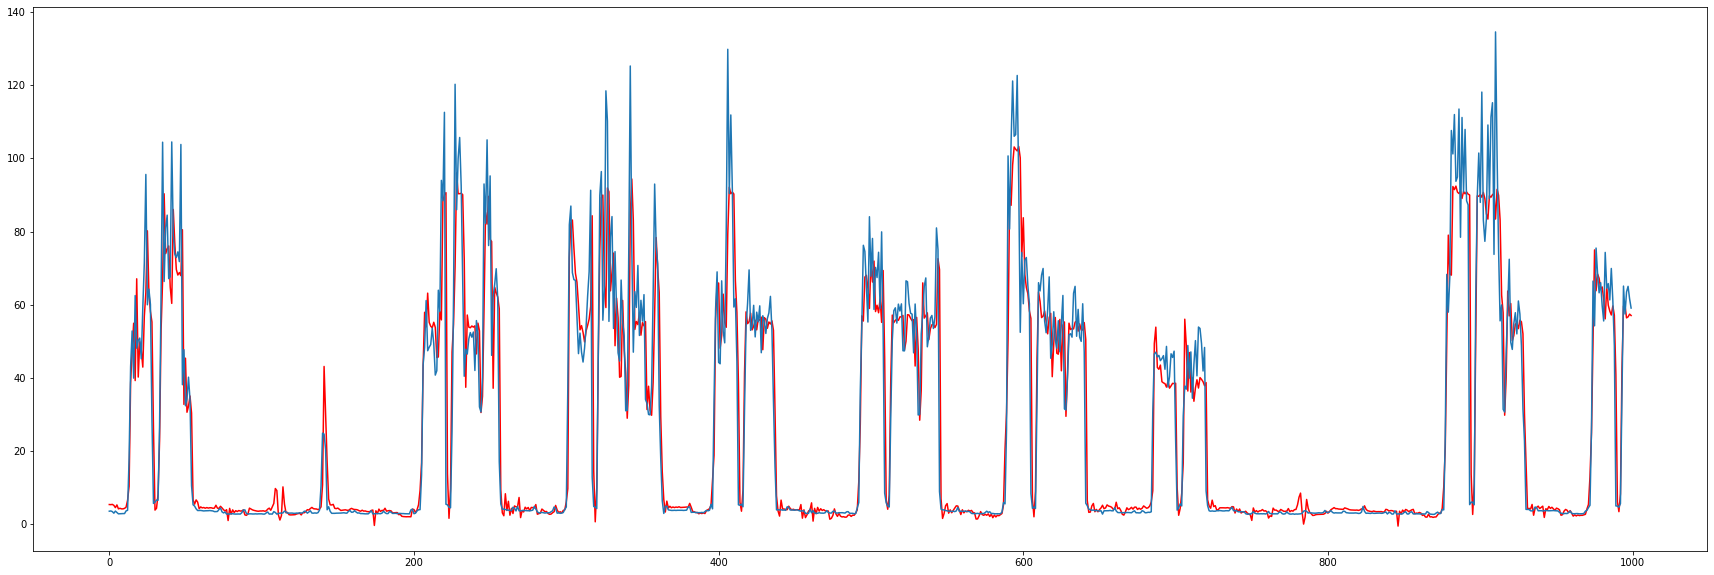

In [39]:
plt.figure(figsize=(30, 10))

plt.plot(pred[:1000], 'r')
plt.plot(y_test[:1000])
plt.savefig('lstm.png')